<a href="https://colab.research.google.com/github/envirodatascience/final-project-go-squirrels/blob/main/Zaya_Go_Squirrels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Squirrels: Statistics and Regression
Central Park's squirrels are more than just cute residents — they are vital in the park's ecosystem, helping to plant trees, spread seeds, and sustain a balance between urban wildlife and green spaces. But their survival depends heavily on two things: access to food and shelter.

Nut- and berry-producing trees are a crucial food source for squirrels, especially as seasons change and natural resources fluctuate. Meanwhile, tree coverage provides them with habitat — protection from predators, safe places to nest, and corridors to travel across the park.

By studying how much of the park's vegetation produces edible food for squirrels, and whether tree density correlates with squirrel distribution, we can better understand how Central Park sustains its squirrel population. This isn't just about counting trees and squirrels — it's about uncovering the invisible relationships that support urban wildlife.

The insights from this analysis could inform urban park management: if parts of the park are under-serving wildlife, simple interventions like planting more nut-bearing trees could boost ecological health without major changes.

---
## In this notebook, I'm investigating the following two questions:
### 1. How much of the Central Park trees are nut/berry producing and therefore edible by squirrels?
### 2. Does tree coverage correlate with squirrel distribution in Central Park?

In [ ]:
#Import packages

import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import plotnine
from plotnine import *
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
!pip install rasterio geopandas
import rasterio
from rasterio.transform import rowcol
from rasterio.mask import mask
import matplotlib.pyplot as plt
import pandas_gbq
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Read in BigQuery Data

In [ ]:
#Authenticate my Google account
from google.colab import auth
auth.authenticate_user()

# Import necessary packages
!pip install --upgrade google-cloud-storage
!pip install geopandas shapely fiona pyproj google-cloud-storage

from google.cloud import storage
from io import BytesIO
import os

# Import BigQuery data: Lakes, Buildings, and Trees in Central Park

In [ ]:
# Set my project ID and GCS bucket info
project_id = "env-617-new-sandbox"
bucket_name = "squirrel_data_617"
file_name = "water_features.csv"

# Create a storage client
client = storage.Client(project=project_id)

# Get the bucket and blob
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_name)

# Download the U.S lakes CSV as bytes and read into pandas
data = blob.download_as_bytes()
df_water = pd.read_csv(BytesIO(data))
df_water.head()

,the_geom,GISPROPNUM,OBJECTID,DEPARTMENT,PARENTID,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,NAME,WF_TYPE,FEATURESTA
0,MULTIPOLYGON (((-74.17136169771383 40.56950391...,R017,1234,R-02,R017,502,51,122,10314,R,unset,NaN,Active
1,MULTIPOLYGON (((-73.8771674901483 40.849658345...,X002,1042,X-06,X002,227,15,52,10460,X,NaN,NaN,Active
2,MULTIPOLYGON (((-74.17653127351284 40.63360714...,R142,1211,R-01,R142,501,49,120,10303,R,unset,NaN,Active
3,MULTIPOLYGON (((-74.12117978149247 40.58886029...,R065,1317,R-02,R065,502,50,122,10304,R,unset,NaN,Active
4,MULTIPOLYGON (((-73.88669221398843 40.90079330...,X092,1065,X-13,X092,226,11,50,10471,X,unset,NaN,Active


In [ ]:
# Get the NYC tree point data blob from BigQuery
blob = bucket.blob('Forestry_Tree_Points_20250408.csv')

# Download the NYC tree point data as bytes and read into pandas
data = blob.download_as_bytes()
df_tree = pd.read_csv(BytesIO(data))
df_tree.head()

,OBJECTID,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,230120,0.0,Retired,Unknown,NaN,B9DDFFE7-7387-4923-91EA-6E9212AA324F,POINT(-73.72963593901264 40.69403944537182),039E4FD7-CFB6-4518-9E16-1E37D10C994A,Unknown - Unknown,2015-06-19 10:39:00.0000000,NaN,NaN,NaN,NaN,POINT (-73.72963593901264 40.69403944537182)
1,268502,8.0,Full,Good,NaN,CDEA211F-C515-4D85-B53A-24A369ABF44A,POINT(-74.13366894015142 40.56652626802944),C72DADDC-2745-4B42-9969-8766ADA2B56C,Acer - maple,2015-07-22 11:44:00.0000000,NaN,NaN,NaN,NaN,POINT (-74.13366894015142 40.56652626802944)
2,572776,0.0,Retired,Unknown,10.0,9AB72953-640F-4A04-AB00-2814F9412FE7,POINT(-73.9293946965878 40.8515468717439),1C439622-3941-43C1-978B-07B5FD90FF0F,Unknown - Unknown,2015-08-25 10:30:28.0000000,NaN,NaN,NaN,NaN,POINT (-73.9293946965878 40.8515468717439)
3,582401,0.0,Stump,Unknown,7.0,D7A58F5E-2BE3-4222-A465-1289D002E270,POINT(-73.91575377982007 40.869686117352636),4B92A177-7F20-464C-8BE3-E8562D4FF901,Unknown - Unknown,2015-08-25 10:56:26.0000000,NaN,NaN,NaN,NaN,POINT (-73.91575377982007 40.869686117352636)
4,590825,2.0,Full,Dead,0.0,79730210-11DB-4616-BF47-4395C4A3D335,POINT(-73.99809492092324 40.578870488397094),73DB7C03-9E63-4F47-AEC2-3BFF8F6A87DB,Unknown - Unknown,2015-08-25 11:19:50.0000000,NaN,NaN,NaN,NaN,POINT (-73.99809492092324 40.578870488397094)


In [ ]:
# Get the building data blob from BigQuery
blob = bucket.blob('building_footprints.csv')

data = blob.download_as_bytes()
df_building = pd.read_csv(BytesIO(data))
df_building.head()

,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,MULTIPOLYGON (((-73.96664570466969 40.62599676...,NaN,3170958,1925.0,08/22/2017,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}
1,MULTIPOLYGON (((-74.16790202462265 40.63936048...,NaN,5028452,1965.0,08/22/2017,Constructed,326368,22.630000,2100,39.0,0,0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520}
2,MULTIPOLYGON (((-74.19510813278613 40.55610681...,NaN,5078368,1970.0,08/22/2017,Constructed,746627,35.760000,2100,51.0,0,0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068}
3,MULTIPOLYGON (((-73.96113466505085 40.57743931...,NaN,3245111,1928.0,08/22/2017,Constructed,786626,37.500000,2100,6.0,0,0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF}
4,MULTIPOLYGON (((-73.75421559146166 40.75591276...,NaN,4161096,1950.0,08/22/2017,Constructed,746409,18.015113,2100,93.0,0,0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D}


# Creating A Shapefile for Central Park

### This step was completed in ArcGIS since there wasn't a readily available shapefile. We used the open street map on ArcGIS as our base map, created a polygon around the edges of Central Park, and exported the shapefile, which is now stored on BigQuery.

In [ ]:
# Get the Central Park shapefile from BigQuery

project_id = "env-617-new-sandbox"
bucket_name = "squirrel_data_617"
shapefile_base = "CentralParkPolygon"
local_dir = "/content/shapefile" #Create a temporary folder called shapefile inside the /content directory

# Make local directory
os.makedirs(local_dir, exist_ok=True)

# Required extensions for a shapefile
extensions = [".shp", ".shx", ".dbf", ".prj"]

# Connect to GCS
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)

# Download each component of the shapefile
for ext in extensions:
    blob_path = shapefile_base + ext
    blob = bucket.blob(blob_path)
    local_path = os.path.join(local_dir, "CentralParkPolygon" + ext)
    blob.download_to_filename(local_path)
    print(f"Downloaded {blob_path} to {local_path}")

Downloaded CentralParkPolygon.shp to /content/shapefile/CentralParkPolygon.shp
Downloaded CentralParkPolygon.shx to /content/shapefile/CentralParkPolygon.shx
Downloaded CentralParkPolygon.dbf to /content/shapefile/CentralParkPolygon.dbf
Downloaded CentralParkPolygon.prj to /content/shapefile/CentralParkPolygon.prj


In [ ]:
central_shp = os.path.join(local_dir, "CentralParkPolygon.shp")
central_shp = gpd.read_file(central_shp)

# Show the first few rows
central_shp.head()

,Id,geometry
0,0,"POLYGON ((-73.95818 40.80061, -73.94942 40.796..."


In [ ]:
central_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Read squirrel data from Github

df_sq = pd.read_csv('https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/refs/heads/main/2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250408.csv')

# Display the first few rows of the dataframe to verify
df_sq.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


## Accessing Tree Canopy Data from GitHub
### Background:
##### Our initial 2020 NYC tree dataset only included street trees and missed much of Central Park. To get a more complete picture, we switched to the USDA Forestry’s 2021 tree canopy coverage data. This raster dataset uses pixel values from 0 to 100 to indicate tree cover density — higher values mean more coverage.

###Data Preparation:
#####The original file was large (~7GB) and covered the entire U.S. To speed up processing in Colab, we clipped the raster to the geographic extent of Central Park using ArcGIS. The clipped file was then uploaded to our GitHub repository. (Note: we clipped by bounding box, not by the exact shape of the park.)

###Why This Works:
#####This clipped version is much faster to work with in Colab. We can still subset it to the exact shape of Central Park later in our code, without dealing with the full national dataset.

In [ ]:

# Change the Raster data CRS to match the shapefile's.
dst_path = "reprojected_raster.tif"

# Define the target CRS (example: EPSG:4326 = WGS84)
dst_crs = 'EPSG:4326'

with rasterio.open('https://raw.githubusercontent.com/envirodatascience/final-project-go-squirrels/main/science_tcc_conus_2021__C.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


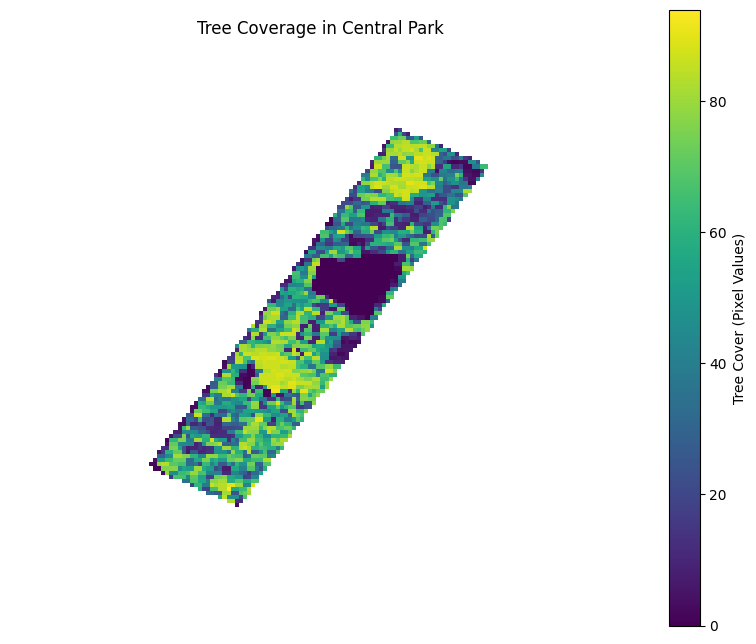

In [ ]:
# Open the reprojected raster
with rasterio.open(dst_path) as reproj:
    image = reproj.read(1).astype('float32')   # Read first band as float32
    profile = reproj.profile
    out_transform = reproj.transform  # Save original transform

    # Reproject shapefile to match raster CRS
    shp = central_shp.to_crs(reproj.crs)

    # Get geometries
    geoms = [feature["geometry"] for feature in shp.__geo_interface__['features']]

# Create a mask: True inside the shapefile area
mask_array = geometry_mask(
    geoms,
    out_shape=image.shape,
    transform=out_transform,
    invert=True  # True inside shapes
)

# Apply mask: outside = np.nan VERY Important for running the regression
out_image = np.where(mask_array, image, np.nan).reshape(1, image.shape[0], image.shape[1])

# Set metadata
out_meta = profile.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": np.nan,
    "dtype": 'float32'
})

# Plot it
plt.figure(figsize=(10, 8))
plt.imshow(out_image[0], cmap='viridis')   # <== use out_image[0] directly
plt.title("Tree Coverage in Central Park")
plt.colorbar(label='Tree Cover (Pixel Values)')
plt.axis('off')
plt.show()

In [ ]:
print(central_shp.crs)

EPSG:4326


# Convert all csv dataframes into shapely geometry objects

This is a necessary step to plot multipolygons and points.

In [ ]:

# Convert the NYC building WKT string in the geometry column to Shapely geometry objects
df_building['the_geom'] = df_building['the_geom'].apply(wkt.loads)

# Convert to GeoDataFrame
df_building = gpd.GeoDataFrame(df_building, geometry='the_geom')

# Set CRS to EPSG:4326 (if the data is in WGS84 lat/lon)
df_building.set_crs(epsg=4326, inplace=True)


,the_geom,NAME,BIN,CNSTRCT_YR,LSTMODDATE,LSTSTATYPE,DOITT_ID,HEIGHTROOF,FEAT_CODE,GROUNDELEV,SHAPE_AREA,SHAPE_LEN,BASE_BBL,MPLUTO_BBL,GEOMSOURCE,GLOBALID
0,"MULTIPOLYGON (((-73.96665 40.626, -73.96685 40...",NaN,3170958,1925.0,08/22/2017,Constructed,96807,29.749853,2100,40.0,0,0,3065220021,3065220021,Photogramm,{31298F86-3088-4F53-B3DB-71A9EFA6FA1F}
1,"MULTIPOLYGON (((-74.1679 40.63936, -74.1679 40...",NaN,5028452,1965.0,08/22/2017,Constructed,326368,22.630000,2100,39.0,0,0,5012640036,5012640036,Photogramm,{F5F8CDA5-69E2-46F8-8F69-BA95C025B520}
2,"MULTIPOLYGON (((-74.19511 40.55611, -74.1952 4...",NaN,5078368,1970.0,08/22/2017,Constructed,746627,35.760000,2100,51.0,0,0,5060190091,5060190091,Photogramm,{9F644794-F72C-4582-9E5E-B337E2B97068}
3,"MULTIPOLYGON (((-73.96113 40.57744, -73.96115 ...",NaN,3245111,1928.0,08/22/2017,Constructed,786626,37.500000,2100,6.0,0,0,3086910048,3086910048,Photogramm,{F916B22D-E25B-44AE-9FA9-2A51191B9CDF}
4,"MULTIPOLYGON (((-73.75422 40.75591, -73.75417 ...",NaN,4161096,1950.0,08/22/2017,Constructed,746409,18.015113,2100,93.0,0,0,4075020005,4075020005,Photogramm,{525F2C24-616B-4F29-98A3-8FEA5D4B1A7D}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082662,"MULTIPOLYGON (((-74.21164 40.54965, -74.21163 ...",NaN,5117672,1984.0,01/22/2019,Constructed,450376,27.000000,2100,65.0,0,0,5070550001,5070557502,Other (Man,{E9A6CF4E-1D03-4C21-9A25-8B526035298D}
1082663,"MULTIPOLYGON (((-73.75619 40.74662, -73.75638 ...",NaN,4446740,1980.0,01/22/2019,Constructed,68691,28.000000,2100,98.0,0,0,4076210001,4076217501,Other (Man,{0FE24292-036D-445A-A8D6-A7D19C4A5CCD}
1082664,"MULTIPOLYGON (((-74.21312 40.55081, -74.21308 ...",NaN,5117196,1980.0,01/22/2019,Constructed,323765,25.000000,2100,59.0,0,0,5070550001,5070557502,Other (Man,{918F2825-D423-4E27-9E59-586D01716F0B}
1082665,"MULTIPOLYGON (((-74.08614 40.60159, -74.08619 ...",NaN,5122282,1986.0,01/22/2019,Constructed,950183,33.000000,2100,104.0,0,0,5031730001,5031737502,Other (Man,{353EADCA-90ED-4738-9A15-0D9A220D79D4}


In [ ]:
# Convert the Water Features WKT string in the geometry column to Shapely geometry objects
df_water['the_geom'] = df_water['the_geom'].apply(wkt.loads)

# Convert to GeoDataFrame
df_water = gpd.GeoDataFrame(df_water, geometry='the_geom')

# Set CRS to EPSG:4326 (if the data is in WGS84 lat/lon)
df_water.set_crs(epsg=4326, inplace=True)


,the_geom,GISPROPNUM,OBJECTID,DEPARTMENT,PARENTID,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,NAME,WF_TYPE,FEATURESTA
0,"MULTIPOLYGON (((-74.17136 40.5695, -74.17139 4...",R017,1234,R-02,R017,502,51,122,10314,R,unset,NaN,Active
1,"MULTIPOLYGON (((-73.87717 40.84966, -73.87717 ...",X002,1042,X-06,X002,227,15,52,10460,X,NaN,NaN,Active
2,"MULTIPOLYGON (((-74.17653 40.63361, -74.17659 ...",R142,1211,R-01,R142,501,49,120,10303,R,unset,NaN,Active
3,"MULTIPOLYGON (((-74.12118 40.58886, -74.12099 ...",R065,1317,R-02,R065,502,50,122,10304,R,unset,NaN,Active
4,"MULTIPOLYGON (((-73.88669 40.90079, -73.88669 ...",X092,1065,X-13,X092,226,11,50,10471,X,unset,NaN,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,"MULTIPOLYGON (((-74.17166 40.60224, -74.17168 ...",R017,1083,R-02,R017,502,"50, 51",122,10314,R,unset,NaN,Active
455,"MULTIPOLYGON (((-74.1928 40.56208, -74.19278 4...",R120,1146,R-03,R120,503,51,123,10312,R,unset,NaN,Active
456,"MULTIPOLYGON (((-74.23446 40.50322, -74.23446 ...",R136,977,R-03,R136,503,51,123,10307,R,NaN,Pond,Active
457,"MULTIPOLYGON (((-74.17429 40.53066, -74.17428 ...",R119,1226,R-03,R119,503,51,123,10312,R,unset,NaN,Active


In [ ]:
df_tree.head()

,OBJECTID,DBH,TPStructure,TPCondition,StumpDiameter,PlantingSpaceGlobalID,Geometry,GlobalID,GenusSpecies,CreatedDate,UpdatedDate,PlantedDate,RiskRating,RiskRatingDate,Location
0,230120,0.0,Retired,Unknown,NaN,B9DDFFE7-7387-4923-91EA-6E9212AA324F,POINT(-73.72963593901264 40.69403944537182),039E4FD7-CFB6-4518-9E16-1E37D10C994A,Unknown - Unknown,2015-06-19 10:39:00.0000000,NaN,NaN,NaN,NaN,POINT (-73.72963593901264 40.69403944537182)
1,268502,8.0,Full,Good,NaN,CDEA211F-C515-4D85-B53A-24A369ABF44A,POINT(-74.13366894015142 40.56652626802944),C72DADDC-2745-4B42-9969-8766ADA2B56C,Acer - maple,2015-07-22 11:44:00.0000000,NaN,NaN,NaN,NaN,POINT (-74.13366894015142 40.56652626802944)
2,572776,0.0,Retired,Unknown,10.0,9AB72953-640F-4A04-AB00-2814F9412FE7,POINT(-73.9293946965878 40.8515468717439),1C439622-3941-43C1-978B-07B5FD90FF0F,Unknown - Unknown,2015-08-25 10:30:28.0000000,NaN,NaN,NaN,NaN,POINT (-73.9293946965878 40.8515468717439)
3,582401,0.0,Stump,Unknown,7.0,D7A58F5E-2BE3-4222-A465-1289D002E270,POINT(-73.91575377982007 40.869686117352636),4B92A177-7F20-464C-8BE3-E8562D4FF901,Unknown - Unknown,2015-08-25 10:56:26.0000000,NaN,NaN,NaN,NaN,POINT (-73.91575377982007 40.869686117352636)
4,590825,2.0,Full,Dead,0.0,79730210-11DB-4616-BF47-4395C4A3D335,POINT(-73.99809492092324 40.578870488397094),73DB7C03-9E63-4F47-AEC2-3BFF8F6A87DB,Unknown - Unknown,2015-08-25 11:19:50.0000000,NaN,NaN,NaN,NaN,POINT (-73.99809492092324 40.578870488397094)


In [ ]:
# Convert the Tree Features WKT string in the geometry column to Shapely geometry objects
df_tree['Geometry'] = df_tree['Geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
df_tree = gpd.GeoDataFrame(df_tree, geometry='Geometry')

# Set CRS to EPSG:4326 (if the data is in WGS84 lat/lon)
df_tree.set_crs(epsg=4326, inplace=True)

#Convert the Squirrel DataFrame to a GeoDataFrame
df_sq = gpd.GeoDataFrame(
    df_sq,
    geometry=gpd.points_from_xy(df_sq.X, df_sq.Y),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

# Subset the U.S- and NYC-level data to Central Park

In [ ]:
filtered_building = gpd.sjoin(df_building, central_shp, predicate="within", how="inner")
filtered_building.info()

filtered_water = gpd.sjoin(df_water, central_shp, predicate="within", how="inner")
filtered_water.info()

filtered_tree = gpd.sjoin(df_tree, central_shp, predicate="within", how="inner")
filtered_tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 61 entries, 52254 to 1077934
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   the_geom     61 non-null     geometry
 1   NAME         23 non-null     object  
 2   BIN          61 non-null     int64   
 3   CNSTRCT_YR   25 non-null     float64 
 4   LSTMODDATE   61 non-null     object  
 5   LSTSTATYPE   59 non-null     object  
 6   DOITT_ID     61 non-null     int64   
 7   HEIGHTROOF   61 non-null     float64 
 8   FEAT_CODE    61 non-null     int64   
 9   GROUNDELEV   61 non-null     float64 
 10  SHAPE_AREA   61 non-null     int64   
 11  SHAPE_LEN    61 non-null     int64   
 12  BASE_BBL     61 non-null     int64   
 13  MPLUTO_BBL   61 non-null     int64   
 14  GEOMSOURCE   60 non-null     object  
 15  GLOBALID     61 non-null     object  
 16  index_right  61 non-null     int64   
 17  Id           61 non-null     int32   
dtypes: float64(3), geome

In [ ]:
# #Save filtered files
# from google.colab import files
# filtered_water.to_csv('filtered_water.csv')
# filtered_building.to_csv('filtered_building.csv')
# files.download('filtered_water.csv')
# files.download ('filtered_building.csv')

In [ ]:
df_sq.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long,geometry
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),POINT (-73.95613 40.79408)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444),POINT (-73.96886 40.78378)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083),POINT (-73.97428 40.77553)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029),POINT (-73.95964 40.79031)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894),POINT (-73.97027 40.77621)


# Plot Everything Inside Central Park On One Map

In [ ]:
central_shp.head()

,Id,geometry
0,0,"POLYGON ((-73.95818 40.80061, -73.94942 40.796..."


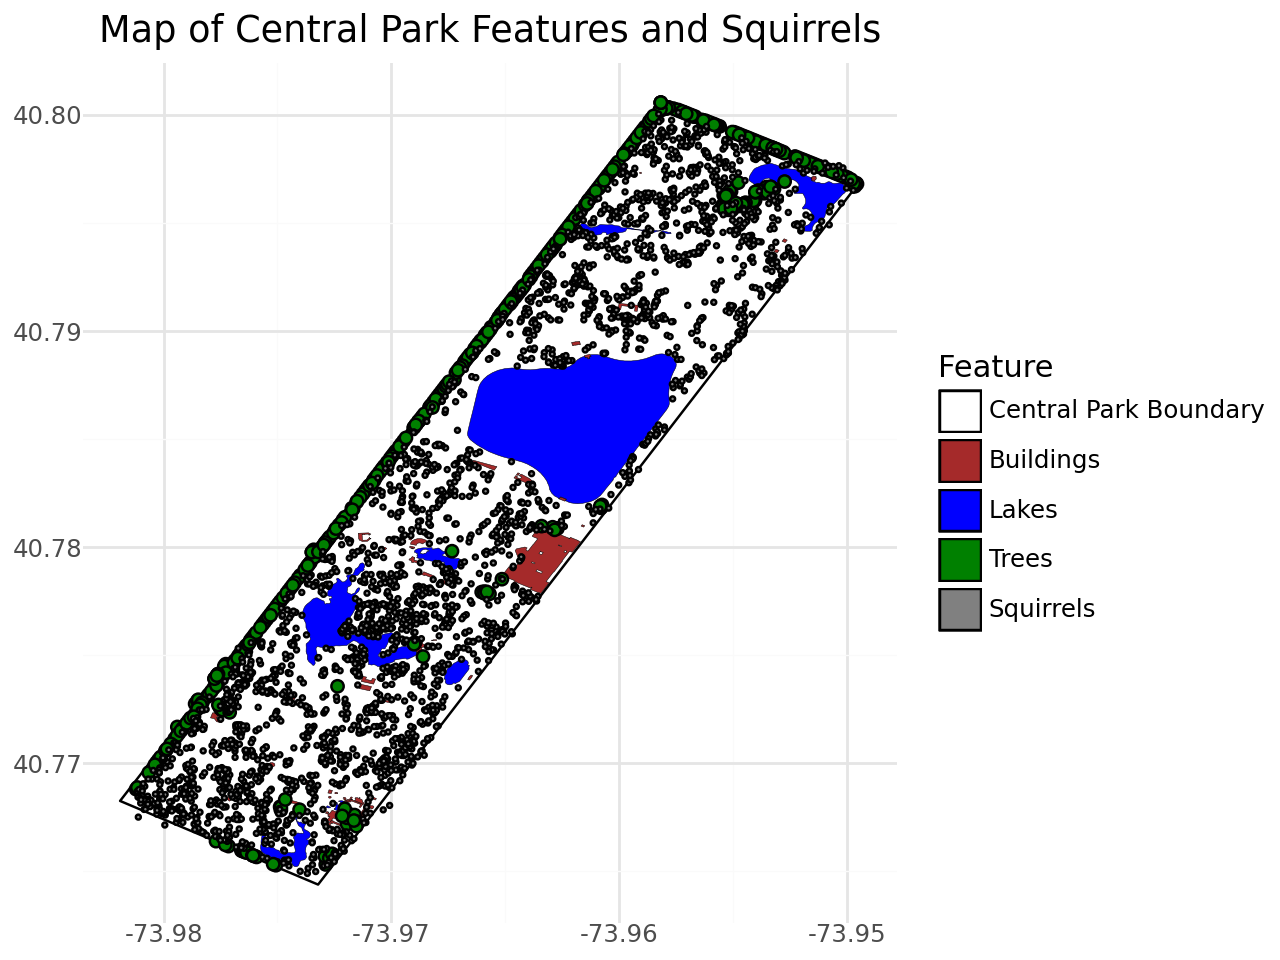

In [ ]:
(
    ggplot()
    + geom_map(central_shp, aes(geometry='geometry', fill='"Central Park Boundary"'), color='black')
    + geom_map(filtered_building, aes(geometry='the_geom', fill='"Buildings"'), size=0.1, color='black')
    + geom_map(filtered_water, aes(geometry='the_geom', fill='"Lakes"'), size=0.1, color='black')
    + geom_map(filtered_tree, aes(geometry='Geometry', fill='"Trees"'), size=2, color='black')
    + geom_map(df_sq, aes(geometry='geometry', fill='"Squirrels"'), color='black')
    + scale_fill_manual(
        values={
            "Central Park Boundary": 'white',
            "Buildings": 'brown',
            "Lakes": 'blue',
            "Trees": 'green',
            "Squirrels": 'grey'
        },
        name="Feature"  # Legend title
    )
    + theme_minimal()
    + labs(title="Map of Central Park Features and Squirrels")
)


In [ ]:
df_sq.columns

Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long', 'geometry'],
      dtype='object')

# How does tree coverage correlate with where squirrels are?

In [ ]:
df_sq.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
filtered_water.head()

,the_geom,GISPROPNUM,OBJECTID,DEPARTMENT,PARENTID,COMMUNITYB,COUNCILDIS,PRECINCT,ZIPCODE,BOROUGH,NAME,WF_TYPE,FEATURESTA,index_right,Id
47,"MULTIPOLYGON (((-73.95328 40.79775, -73.9531 4...",M010,911,M-13,M010,164,8,22,10025,M,NaN,NaN,Active,0,0
73,"MULTIPOLYGON (((-73.98109 40.76824, -73.98102 ...",M010,1361,M-13,M010,NaN,NaN,NaN,NaN,NaN,NaN,Fountain,Active,0,0
93,"MULTIPOLYGON (((-73.97176 40.76793, -73.97174 ...",M010,1049,M-13,M010,164,8,22,10023,M,NaN,NaN,Active,0,0
135,"MULTIPOLYGON (((-73.96231 40.78222, -73.96257 ...",M010,912,M-13,M010,164,8,22,10024,M,NaN,NaN,Active,0,0
219,"MULTIPOLYGON (((-73.96665 40.77457, -73.96662 ...",M010,915,M-13,M010,164,8,22,10023,M,NaN,NaN,Active,0,0


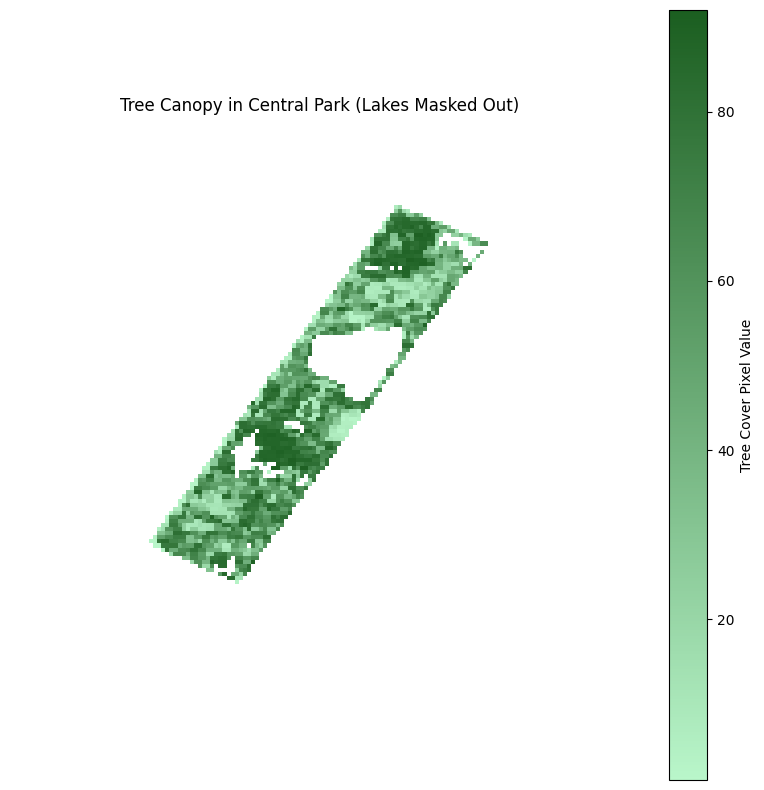

In [ ]:

# 1. Rasterize the lakes
lake_mask = features.rasterize(
    [(geom, 1) for geom in filtered_water.the_geom],
    out_shape=out_image[0].shape,
    transform=out_meta['transform'],
    fill=0,
    dtype=np.uint8
)

# 2. Mask out the lakes from the tree canopy raster
# Set pixels inside lakes to NaN
out_image_masked = np.where(lake_mask == 1, np.nan, out_image)

# Plot to check whether we've masked out the lakes successfully
# Define a custom green color gradient to make sure that NaNs are clear white
green_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_green",
    ["#b9f6ca", "#1b5e20"]  # light green to dark green
)

plt.figure(figsize=(10, 10))
plt.imshow(out_image_masked[0], cmap=green_cmap)
plt.title("Tree Canopy in Central Park (Lakes Masked Out)")
plt.axis('off')
plt.colorbar(label="Tree Cover Pixel Value")
plt.show()

# Regression: Tree coverage per pixel and Squirrel counts per pixel

In [ ]:

# Step 1: Map squirrel points to (row, col) pixels
df_sq['row'], df_sq['col'] = zip(*[
    rowcol(out_transform, x, y)
    for x, y in zip(df_sq.geometry.x, df_sq.geometry.y)
])

# Step 2: Aggregate squirrel counts per pixel
squirrel_counts = df_sq.groupby(['row', 'col']).size().reset_index(name='squirrel_count')

# Step 3: Create a DataFrame of all valid pixels (inside Central Park)
valid_pixels = np.argwhere(~np.isnan(out_image[0]))

# Make it a dataframe
pixels_df = pd.DataFrame(valid_pixels, columns=['row', 'col'])

# Step 4: Merge squirrel counts into all pixels (left join)
pixels_df = pixels_df.merge(squirrel_counts, on=['row', 'col'], how='left')

# Step 5: Fill missing squirrel counts with zero because that indicates there's tree coverage but there's no squirrels.
pixels_df['squirrel_count'] = pixels_df['squirrel_count'].fillna(0)

# Step 6: Extract tree canopy value for each pixel
pixels_df['tree_cover'] = pixels_df.apply(
    lambda row: out_image[0, int(row['row']), int(row['col'])],
    axis=1
)



In [ ]:
df_sq.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   X                                           3023 non-null   float64 
 1   Y                                           3023 non-null   float64 
 2   Unique Squirrel ID                          3023 non-null   object  
 3   Hectare                                     3023 non-null   object  
 4   Shift                                       3023 non-null   object  
 5   Date                                        3023 non-null   int64   
 6   Hectare Squirrel Number                     3023 non-null   int64   
 7   Age                                         2902 non-null   object  
 8   Primary Fur Color                           2968 non-null   object  
 9   Highlight Fur Color                         1937 non-null   object

In [ ]:
pixels_df.head()

,row,col,squirrel_count,tree_cover
0,21,94,0.0,7.0
1,21,95,0.0,18.0
2,22,94,1.0,26.0
3,22,95,0.0,60.0
4,22,96,1.0,18.0


In [ ]:
# Step 7: Run the regression
X = sm.add_constant(pixels_df['tree_cover'])
y = pixels_df['squirrel_count']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         squirrel_count   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     249.8
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.20e-53
Time:                        13:31:40   Log-Likelihood:                -4724.9
No. Observations:                2452   AIC:                             9454.
Df Residuals:                    2450   BIC:                             9465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3852      0.062      6.210      0.0

## Interpretation:
`tree_cover` (independent variable) — the value of tree cover per pixel, ranging from 0 (no trees) to 100 (full tree cover).

`squirrel_count` (dependent variable) — the number of squirrels observed in each pixel.

For every 1-unit increase in tree coverage (pixel value), the model predicts about 0.0181 more squirrels per pixel.

`p-value` for tree_cover < 0.001 (0.000)

This means the relationship is statistically significant — in other words, it's very unlikely to be due to chance.

`R-squared = 0.093`

My model explains only 9.3% of the variation in squirrel counts. So while the tree coverage has a significant effect, it doesn't explain much of what's going on.

Tree coverage is positively and significantly related to squirrel counts — areas with more trees tend to have more squirrels.

However, the effect is quite small, and most of the variation in squirrel distribution is due to other factors (perhaps due to food trees, human activity, ground cover, etc.).

This makes sense — tree coverage might be necessary, but not sufficient on its own to predict squirrel populations well.


# How much of the Central Park trees are nut/berry producing?

In [ ]:
tree_count = filtered_tree.GenusSpecies.value_counts().reset_index()

In [ ]:
tree_count

,GenusSpecies,count
0,Quercus palustris - pin oak,245
1,Ginkgo biloba - maidenhair tree,100
2,Ulmus americana - American elm,39
3,Platanus x acerifolia - London planetree,15
4,Malus - apple,15
5,Gleditsia triacanthos var. inermis - Thornless...,7
6,Pinus strobus - eastern white pine,7
7,Quercus rubra - northern red oak,6
8,Acer rubrum 'Armstrong' - 'Armstrong' Red maple,5
9,Betula populifolia - gray birch,5


According to the internet, the following species of trees produce something edible by squirrels.

Quercus palustris - pin oak (Acorns)

Quercus rubra - northern red oak (Acorns)

Quercus acutissima - sawtooth oak (Acorns)

Quercus coccinea - scarlet oak (Acorns)

Quercus bicolor - swamp white oak (Acorns)

Carya glabra - pignut hickory (Hickory nuts)

Juglans nigra - black walnut (Walnuts)

Fagus grandifolia - American beech (Beechnuts)

Morus - mulberry (Berries)

Malus - apple (Fruit/fallen apples)

Crataegus - hawthorn (Berries)

Amelanchier - serviceberry (Berries)

Celtis occidentalis - common hackberry (Berries)

In [ ]:
# Start with food_tree column set to 0
tree_count['food_tree'] = 0

# List of edible trees
edible_trees = [
    "Quercus palustris - pin oak",
    "Quercus rubra - northern red oak",
    "Quercus acutissima - sawtooth oak",
    "Quercus coccinea - scarlet oak",
    "Quercus bicolor - swamp white oak",
    "Carya glabra - pignut hickory",
    "Juglans nigra - black walnut",
    "Fagus grandifolia - American beech",
    "Morus - mulberry",
    "Malus - apple",
    "Crataegus - hawthorn",
    "Amelanchier - serviceberry",
    "Celtis occidentalis - common hackberry"
]

# Loop through each tree name
for tree in edible_trees:
    tree_count.loc[tree_count['GenusSpecies'].str.startswith(tree), 'food_tree'] = 1

In [ ]:
#Check if it worked
tree_count.head()

,GenusSpecies,count,food_tree
0,Quercus palustris - pin oak,245,1
1,Ginkgo biloba - maidenhair tree,100,0
2,Ulmus americana - American elm,39,0
3,Platanus x acerifolia - London planetree,15,0
4,Malus - apple,15,1


In [ ]:
# Get the total count of food producing trees
tree_count['total_food_tree'] = tree_count['count']*tree_count['food_tree']
tree_count.head()

,GenusSpecies,count,food_tree,total_food_tree
0,Quercus palustris - pin oak,245,1,245
1,Ginkgo biloba - maidenhair tree,100,0,0
2,Ulmus americana - American elm,39,0,0
3,Platanus x acerifolia - London planetree,15,0,0
4,Malus - apple,15,1,15


## Nut/berry producing trees in Central Park
#### Out of the 504 trees on the Northwestern side of Central Park, 281 trees are nut/berry producing and thus edible by squirrels.

##### This is equivalent to 56% of the total trees.

In [ ]:
tree_count['count'].sum()

np.int64(504)

In [ ]:
tree_count['total_food_tree'].sum()

np.int64(281)

# Conclusion

According to the Central Park Conservancy, the Central Park has approximately 18,000 trees.

Assuming that the 504 trees in our data represents our study area, there are approximately 10,080 trees that produce food for the park's 3023 squirrels.

This means there are approximately 3.34 nut/berry-producing trees per squirrel in Central Park.

In urban settings, typical squirrel densities range from 1 to 10 squirrels per hectare, depending on food and shelter availability. Central Park covers 843 acres (around 341 hectares), which means there are 8.8 squirrels per hectare. Considering there are repetitive counts of the same squirrels in our data, the average density of 3023 squirrels in such a large area could be considered moderately high, but it's still within reasonable limits for an urban park setting.

The 3.34 trees per squirrel ratio is likely a healthy one in this context, though it could vary depending on the exact size and quality of the trees.

This suggests that the number of trees in Central Park should support a healthy squirrel population, assuming there are no significant disturbances.